# A computational introduction to stochastic differential equations.

Lecture 4.

https://github.com/spdes/computational-sde-intro-lecture.

Solve a Kolmogorov forward equation (a.k.a. Fokker--Planck) using finite difference.

In [1]:
import math
import jax
import jax.numpy as jnp
import jax.scipy.stats
import matplotlib.pyplot as plt
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
a, b = -2., 1.

def drift(x):
    return a * x


def dispersion(x):
    return b * x

In [3]:
dt = 2e-5
T = 10000
ts = jnp.linspace(dt, dt * T, T)

m0 = 2.
var0 = 1.

In [4]:
def simulate_true_trajectory(key):
    x0 = m0 + math.sqrt(var0) * jax.random.normal(key)

    key, _ = jax.random.split(key)
    ws = jnp.cumsum(math.sqrt(dt) * jax.random.normal(key, (T, )))

    return x0 * jnp.exp((a - b ** 2 / 2) * ts + b * ws)

In [5]:
key = jax.random.PRNGKey(999)

num_trajs = 2000
keys = jax.random.split(key, num=num_trajs)
true_trajectories = jax.vmap(simulate_true_trajectory, in_axes=[0])(keys)

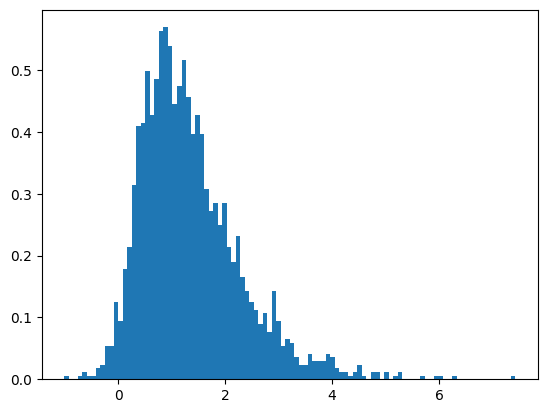

In [7]:
_ = plt.hist(true_trajectories[:, -1], density=True, bins=100)

In [8]:
N = 500
z = 3
xs = jnp.linspace(-2, 6, N)
dx = xs[1] - xs[0]

In [9]:
def fpk_operator(ps):
    """Kolmogorov forward equation operator (for unidimensional process)
    """
    derivative_drift = a
    gamma = dispersion(xs) ** 2
    derivative_gamma = 2 * b ** 2 * xs
    second_derivative_gamma = 2 * b ** 2
    derivative_p = jnp.gradient(ps, dx)
    second_derivative_p = jnp.gradient(jnp.gradient(ps, dx), dx)

    part1 = -(derivative_drift * ps + drift(xs) * derivative_p)
    return part1 + 0.5 * (second_derivative_gamma * ps + 2 * derivative_gamma * derivative_p + gamma * second_derivative_p)

def euler(ps):
    r"""p_k \approx p_{k-1} + fpk_operator(p_{k-1}) * dt
    """
    return ps + fpk_operator(ps) * dt

def solve_fpk(p0):
    def scan_body(carry, _):
        ps = euler(carry)
        return ps, ps
    _, densities = jax.lax.scan(scan_body, p0, ts)
    return densities

In [10]:
p0 = jax.scipy.stats.norm.pdf(xs, m0, jnp.sqrt(var0))
densities = solve_fpk(p0)

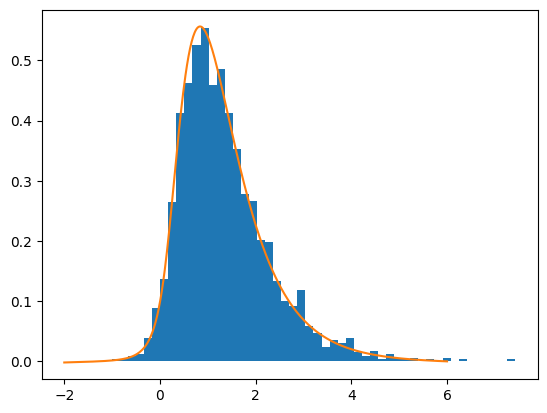

In [11]:
idx = -1
_ = plt.hist(true_trajectories[:, idx], density=True, bins=50)
_ = plt.plot(xs, densities[idx, :])